In [1]:
#Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
import seaborn as sns
import os

import matplotlib.dates as mdates
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_csv('takehome_user_engagement.csv')
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
df['user_id'].nunique()

8823

This shows we have 207,917 total logins from 8,823 unique users

In [5]:
# convert time_stamp to datetime
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [7]:
def check_adopted(df, time_stamp_column):
    """
    Checks if users logged in on at least 3 separate days within any 7-day period.

    Parameters:
    df (pd.DataFrame): The DataFrame containing login data.
    time_stamp_column (str): The name of the datetime column.

    Returns:
    pd.DataFrame: A DataFrame with user IDs and a flag indicating if the condition is met.
    """
    global user_groups
    # Ensure the timestamp column is in datetime format
    df[time_stamp_column] = pd.to_datetime(df[time_stamp_column])

    # Extract the date part of the timestamps
    df['login_date'] = df[time_stamp_column].dt.date

    # Group by user ID and aggregate login dates
    user_groups = df.groupby('user_id')['login_date'].apply(list).reset_index()

    # Function to check the condition for a single user's login dates
    def has_three_logins_in_seven_days(login_dates):
        sorted_dates = sorted(set(login_dates))  # Remove duplicates and sort dates
        for i in range(len(sorted_dates) - 2):
            # Check if a 7-day period includes at least 3 separate days
            if (sorted_dates[i + 2] - sorted_dates[i]).days <= 7:
                return True
        return False

    # Apply the check to each user's login dates
    user_groups['adopted'] = user_groups['login_date'].apply(has_three_logins_in_seven_days)

    return user_groups[['user_id', 'adopted']]

In [8]:
check_adopted(df,'time_stamp')

,user_id,adopted
0,1,False
1,2,True
2,3,False
3,4,False
4,5,False
...,...,...
8818,11996,False
8819,11997,False
8820,11998,False
8821,11999,False


In [9]:
# Count how many users have 'three_days_in_seven' as True
count = user_groups['adopted'].sum()

print(f"Number of users with 3 logins in a 7-day period: {count}")

Number of users with 3 logins in a 7-day period: 1656


In [10]:
user_groups.head()

,user_id,login_date,adopted
0,1,[2014-04-22],False
1,2,"[2013-11-15, 2013-11-29, 2013-12-09, 2013-12-2...",True
2,3,[2013-03-19],False
3,4,[2013-05-22],False
4,5,[2013-01-22],False


In [11]:
try:
    # Attempt to read the file with default utf-8 encoding
    df_users = pd.read_csv('takehome_users.csv')
except UnicodeDecodeError:
    # If utf-8 fails, try an alternative encoding
    df_users = pd.read_csv('takehome_users.csv', encoding='latin1')

df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [12]:
df_users = df_users.drop(columns=['name', 'email'])

In [13]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   creation_source             12000 non-null  object 
 3   last_session_creation_time  8823 non-null   float64
 4   opted_in_to_mailing_list    12000 non-null  int64  
 5   enabled_for_marketing_drip  12000 non-null  int64  
 6   org_id                      12000 non-null  int64  
 7   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(2)
memory usage: 750.1+ KB


In [14]:
df_users.nunique()

object_id                     12000
creation_time                 11996
creation_source                   5
last_session_creation_time     8821
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2564
dtype: int64

In [15]:
df_users = df_users.drop(columns=['org_id', 'invited_by_user_id'])

In [16]:
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'], format='%Y-%m-%d %H:%M:%S')
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'], unit='s')
df_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0


In [17]:
# add account age feature
latest_activity_date = max(df_users['last_session_creation_time'])
df_users['account_age_in_days'] = latest_activity_date - df_users['creation_time']
df_users['account_age_in_days'] = df_users['account_age_in_days'].dt.days
df_users.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age_in_days
0,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,45
1,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,203
2,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,443
3,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,381
4,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,505


In [18]:
# add last active feature
latest_activity_date = max(df_users['last_session_creation_time'])
df_users['days_since_last_active'] = latest_activity_date - df_users['last_session_creation_time']
df_users['days_since_last_active'] = df_users['days_since_last_active'].dt.days

In [19]:
merged_df = pd.merge(user_groups, df_users, left_on='user_id', right_on='object_id')

In [20]:
merged_df.head()

,user_id,login_date,adopted,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age_in_days,days_since_last_active
0,1,[2014-04-22],False,1,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,45,45.0
1,2,"[2013-11-15, 2013-11-29, 2013-12-09, 2013-12-2...",True,2,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,203,67.0
2,3,[2013-03-19],False,3,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,443,443.0
3,4,[2013-05-22],False,4,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,381,380.0
4,5,[2013-01-22],False,5,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,505,500.0


In [21]:
merged_df = merged_df.drop(columns=['login_date', 'object_id'])

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   adopted                     8823 non-null   bool          
 2   creation_time               8823 non-null   datetime64[ns]
 3   creation_source             8823 non-null   object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    8823 non-null   int64         
 6   enabled_for_marketing_drip  8823 non-null   int64         
 7   account_age_in_days         8823 non-null   int64         
 8   days_since_last_active      8823 non-null   float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 560.2+ KB


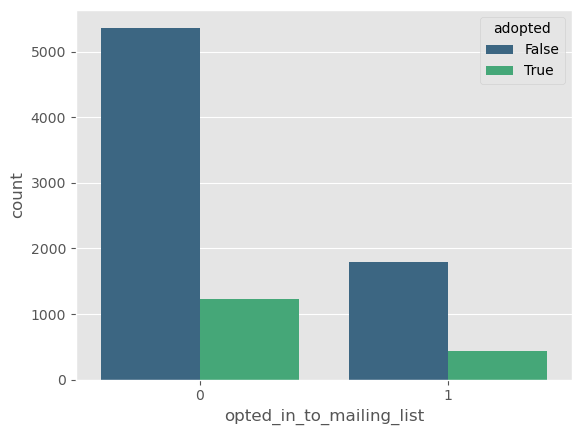

In [23]:
mail_count = sns.countplot(x='opted_in_to_mailing_list', data=merged_df, hue='adopted', palette='viridis')

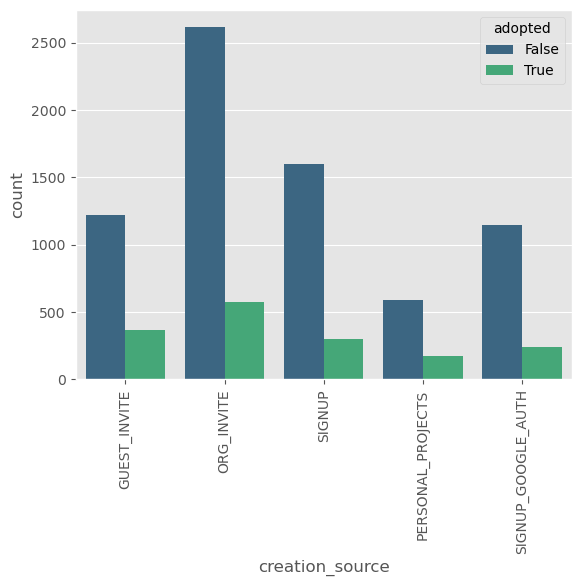

In [24]:
source_count = sns.countplot(x='creation_source', data=merged_df, hue='adopted', palette='viridis')
source_count = plt.xticks(rotation=90)

In [25]:
merged_df.groupby('creation_source')['adopted'].apply(lambda x: sum(x)/len(x))

creation_source
GUEST_INVITE          0.232368
ORG_INVITE            0.180050
PERSONAL_PROJECTS     0.225131
SIGNUP                0.159115
SIGNUP_GOOGLE_AUTH    0.172563
Name: adopted, dtype: float64

Guest invite and personal projects have the highest adoption rates

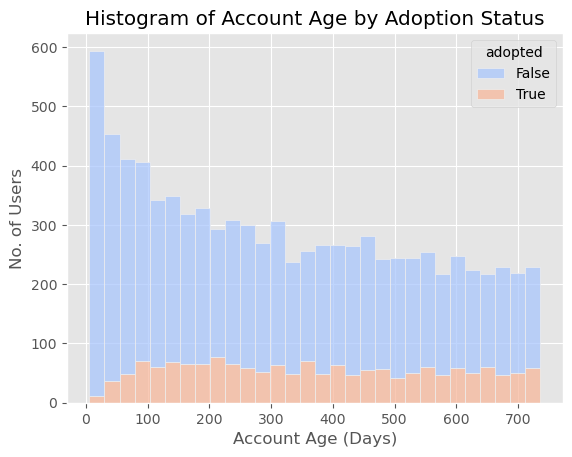

In [26]:
age_hist = sns.histplot(merged_df, x='account_age_in_days', hue='adopted', multiple="stack", bins=30, kde=False, palette="coolwarm")
age_hist = plt.xlabel('Account Age (Days)')
age_hist = plt.ylabel('No. of Users')
age_hist = plt.title('Histogram of Account Age by Adoption Status')

Newer accounts have a far lower adoption rate than older accounts

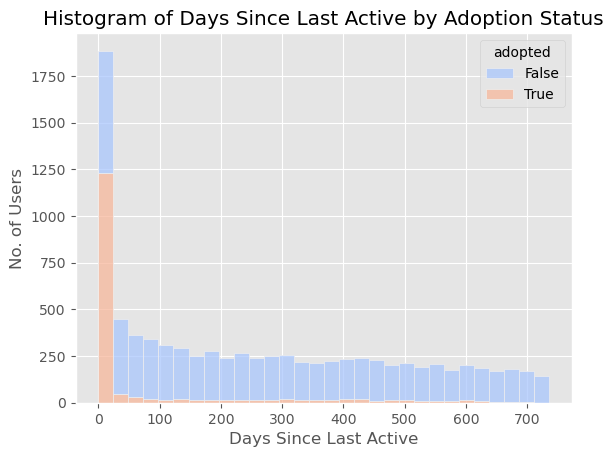

In [27]:
sns.histplot(merged_df, x='days_since_last_active', hue='adopted', multiple="stack", bins=30, kde=False, palette="coolwarm")

# Add labels and title
plt.xlabel('Days Since Last Active')
plt.ylabel('No. of Users')
plt.title('Histogram of Days Since Last Active by Adoption Status')

# Show the plot
plt.show()

Users who have been active in the last 25 days are far more likely to be adopted users

In [28]:
# Create dummies for the 'creation_source' column
creation_source_dummies = pd.get_dummies(merged_df['creation_source'], prefix='creation_source')

# Merge the dummies back into the original dataframe
merged_df = pd.concat([merged_df, creation_source_dummies], axis=1)

# Show the updated dataframe
merged_df.head()

,user_id,adopted,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,account_age_in_days,days_since_last_active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,False,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,45,45.0,True,False,False,False,False
1,2,True,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,203,67.0,False,True,False,False,False
2,3,False,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,443,443.0,False,True,False,False,False
3,4,False,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,381,380.0,True,False,False,False,False
4,5,False,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,505,500.0,True,False,False,False,False


In [29]:
# For modeling we'll drop unneeded features
merged_df = merged_df.drop(columns=['user_id', 'creation_time', 'last_session_creation_time','creation_source'])

In [30]:
y = merged_df['adopted']
X = merged_df.drop('adopted', axis=1)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, stratify=y, random_state=9)

In [31]:
# Model using Random Forest Classifier
rf = RandomForestClassifier(random_state=9, class_weight='balanced')

params = {'n_estimators': [1, 10, 25, 50, 100, 200, 300]}
model = GridSearchCV(rf, params)
model.fit(Xtrain, ytrain)
print(f'Best parameters: {model.best_params_}')
print(f'Best average precision: {model.best_score_}')

Best parameters: {'n_estimators': 200}
Best average precision: 0.9552670279256382


In [32]:
# Model Evaluation
model = RandomForestClassifier(random_state=9, class_weight='balanced', n_estimators=200)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)
print(f'Accuracy of test set: {accuracy_score(ytest, ypred)}')
print(classification_report(ytest, ypred))

Accuracy of test set: 0.9605621033544878
              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1792
        True       0.93      0.85      0.89       414

    accuracy                           0.96      2206
   macro avg       0.95      0.92      0.93      2206
weighted avg       0.96      0.96      0.96      2206



In [33]:
# Feature Importance
fi = pd.Series(model.feature_importances_, index=X.columns)
fi = fi.sort_values(ascending=False)
fi

days_since_last_active                0.685529
account_age_in_days                   0.288184
opted_in_to_mailing_list              0.005390
enabled_for_marketing_drip            0.004767
creation_source_GUEST_INVITE          0.004253
creation_source_SIGNUP                0.003969
creation_source_ORG_INVITE            0.002940
creation_source_SIGNUP_GOOGLE_AUTH    0.002570
creation_source_PERSONAL_PROJECTS     0.002397
dtype: float64

Days since last active is by far the most important feature at 68%. I would send push notifications to users when they go inactive for an extended number of days. The threshold viewed during EDA seemed to be 25 days or less would make a user far more likely to be an adopted user. Account age in days is the second most important at 28%, but there is nothing that can be done there to speed along the passage of time. All of the other features only account for 2.7% importance with the most important of thoese being opted in for mailing list so I would incentivize users to opt in.